In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Dropout, Input,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.constraints import UnitNorm, NonNeg

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
# enable eager mode
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [3]:
df = pd.read_csv("/home/summerxyt/ml_data/ml-latest-small/ratings.csv")
train_data = df.sample(frac=1)

In [4]:
# Normalize data
train_data_mean = df.mean()
train_data_std = df.std()
train_data['rating']  = (train_data['rating'] - 2.5)/2.5

In [5]:
def build_model1():
    """ Build a vanilla neural network predicting rating given user_id and movie_id.
    """
    user = Input(shape=(1,))
    movie = Input(shape=(1,))
    # 611 = max_user_id + 1, 193610 = max_movie_id + 1
    # TODO(summerxyt): Read csv and programatically get the number
    user_embedding = Flatten()(
        Embedding(611,32,  embeddings_regularizer=l2(0.01), name='user_embedding')(user))
    movie_embedding = Flatten()(
        Embedding(193610, 64, embeddings_regularizer=l2(0.01), name='movie_embedding')(movie))
    x = tf.keras.layers.concatenate([user_embedding, movie_embedding])
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    y = Dense(1, activation='tanh')(x)
    model = Model(inputs=[user, movie], outputs=y)
    model.compile(optimizer='adagrad', loss='mean_squared_error')
    return model

def build_model2():
    """ Build a model that the rating equals the dot multiplication of user embedding and moving
           embedding.
           
           IMO, this is similar to matrix factoraization.
    """
    user = Input(shape=(1,))
    movie = Input(shape=(1,))
    # TODO(summerxyt): It might be better to use embeddings_constraints. But tf and keras throws
    # an error I couldn't figure out why.
    user_embedding = Flatten()(
        Embedding(611,15,embeddings_regularizer=l2(0.01),  name='user_embedding')(user))
    movie_embedding = Flatten()(
        Embedding(193610, 15,embeddings_regularizer=l2(0.01), name='movie_embedding')(movie))  
    y = tf.keras.layers.Dot(axes=-1)([user_embedding, movie_embedding])

    model = Model(inputs=[user, movie], outputs=y)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
model = build_model1()

history = model.fit(x=[train_data.userId.values, train_data.movieId.values],
                    y=train_data.rating.values,
                    batch_size=2048*32,
                    #shuffle=True,
                    epochs=1000,
                    validation_split = 0.2,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)],
                    verbose = 0)

In [7]:
history.history['val_loss'][-1]

0.16197097301483154

In [8]:
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
movie_embeddings = model.get_layer('movie_embedding').get_weights()[0]

In [9]:
movieIds = df.movieId.unique()
movieIds.shape

(9724,)

In [10]:
movie_embeddings_trunc = np.zeros((movieIds.shape[0],movie_embeddings.shape[1]))
for new_row, movie_id in enumerate(movieIds):
    movie_embeddings_trunc[new_row] = movie_embeddings[movie_id]

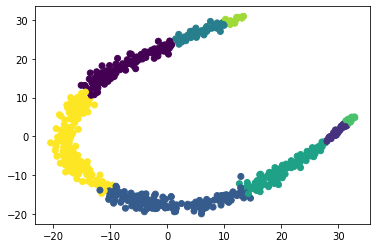

In [11]:
users_clusters = KMeans(n_clusters=8).fit_predict(user_embeddings[1:])
users_tsne = TSNE(n_components=2).fit_transform(user_embeddings[1:])
plt.scatter(users_tsne[:,0], users_tsne[:,1], c=users_clusters)

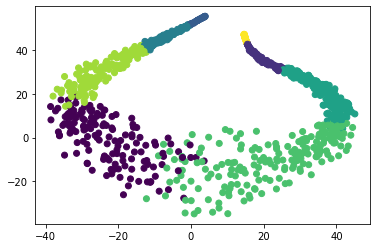

In [12]:
movies_clusters = MiniBatchKMeans(n_clusters=8).fit_predict(movie_embeddings_trunc)
#movies_clusters = KMeans(n_clusters=8, n_jobs=None).fit_predict(movie_embeddings_trunc)
movies_tsne = TSNE(n_components=2).fit_transform(movie_embeddings_trunc)
#just plot the first 1000 movies
plt.scatter(movies_tsne[:1000,0], movies_tsne[:1000,1], c=movies_clusters[:1000])

In [13]:
#np.save('movies_clusters_trunc.txt', movies_clusters)
#movie_clusters_trunc = np.load('movies_clusters_trunc.txt.npy')

In [14]:
def get_movie_clusters(movie_clusters_trunc, movieIds):
    
    def _get_movie_clusters(movie_clusters_trunc, movieIds):
        mapping = {}
        for new_row, movie_id in enumerate(movieIds):
            mapping[movie_id] = movie_clusters_trunc[new_row]
        return mapping
    
    movie_to_cluster = _get_movie_clusters(movie_clusters_trunc, movieIds)
    
    def _cluster_to_movie_id_list(movie_to_cluster):
        d = {}
        for movie_id, cluster_id in movie_to_cluster.items():
            if cluster_id not in d:
                d[cluster_id] = []
            d[cluster_id].append(movie_id)
        return d
    
    return _cluster_to_movie_id_list(movie_to_cluster)

def get_readable_clusters(cluster_to_movie_id_list):
    movies = pd.read_csv("/home/summerxyt/ml_data/ml-latest-small/movies.csv")
    
    d = {}
    for cluster, movie_id_list in cluster_to_movie_id_list.items():
        d[cluster] = movies[movies['movieId'].isin(movie_id_list)]
    
    return d

In [15]:
clusters = get_movie_clusters(movies_clusters, movieIds)
readable_clusters = get_readable_clusters(clusters)

In [17]:
cluster_for_toy_story = None
for c, l in clusters.items():
    if 1 in l:
        cluster_for_toy_story = c
        break
readable_clusters[cluster_for_toy_story]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
15,16,Casino (1995),Crime|Drama
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
32,34,Babe (1995),Children|Drama
33,36,Dead Man Walking (1995),Crime|Drama
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
52,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
